<a href="https://colab.research.google.com/github/pangweijlu/dceesite/blob/master/fishgill_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We first start from detect the lamilar fusion

In [ ]:
!pip install gdown  # gdown is used to download large files from google drive.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Download the gill dataset

In [ ]:
!gdown https://drive.google.com/uc?id=1VZ00_mogQK09qob6U0QCZOQppUXIi7oE # download the zip file

Downloading...
From: https://drive.google.com/uc?id=1VZ00_mogQK09qob6U0QCZOQppUXIi7oE
To: /content/tiles_10.zip
100% 2.31G/2.31G [00:10<00:00, 218MB/s]


In [ ]:
import os
import zipfile

local_zip = '/content/tiles_10.zip'  # you may need to change the path based on your own enviroment
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading data and perform data augmentation.

 https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

In [2]:


from keras.preprocessing.image import ImageDataGenerator

path = '/content/drive/MyDrive/fishgill' # you may need to change the path based on your own enviroment

classes=["fusion",  "normal"]
num_classes = len(classes)
print(num_classes)
batch_size=32

#split data into train and test
datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode="nearest", rescale=1./255, validation_split=0.15)

#load training image set
train_gen = datagen.flow_from_directory(directory=path, 
                                              target_size=(512, 512),
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True, classes=classes,
                                              batch_size=batch_size, 
                                              color_mode="rgb")
#load testing set
test_gen = datagen.flow_from_directory(directory=path, 
                                              target_size=(512, 512),
                                              class_mode='categorical',
                                              subset='validation',
                                              shuffle=True, classes=classes,
                                              batch_size=batch_size, 
                                              color_mode="rgb")



2
Found 2984 images belonging to 2 classes.
Found 526 images belonging to 2 classes.


In [ ]:
train_gen[0][0].shape

(32, 512, 512, 3)

In [ ]:
# check if we are using GPU
import tensorflow as tf
tf.test.gpu_device_name()  # test if GPU is availabe. GPU will be much faster. 
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15370596068883630
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14465892352
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5125874423803520678
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

Transfer learning with VGG16

code taken from a student Sally Tian

In [3]:
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Conv3D, MaxPooling3D,GlobalAveragePooling3D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(512, 512, 3))
base_model.trainable=False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(base_model.input, predictions)

opt = Adam(lr=5e-4,decay=1e-7)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

58900480/58889256 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [5]:
from sklearn.utils import class_weight 
import numpy as np

class_weights1 = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(train_gen.classes),y=train_gen.classes)

train_class_weights1 = dict(enumerate(class_weights1))
print(train_class_weights1)

{0: 3.3229398663697105, 1: 0.5885601577909271}


In [ ]:
epoch = 5  # choose the value for this hyperparameter wisely.
# class_weights = {0:5, 1:1}
class_weights = train_class_weights1
# fit the model
history1 = model.fit(train_gen, steps_per_epoch=len(train_gen), validation_steps=len(test_gen), validation_data=test_gen, epochs=epoch, class_weight=class_weights,verbose=1)


Epoch 1/5
 1/94 [..............................] - ETA: 2:40:00 - loss: 0.8885 - accuracy: 0.6562

In [ ]:
model.save('/content/mymodel') # save the model

NameError: ignored

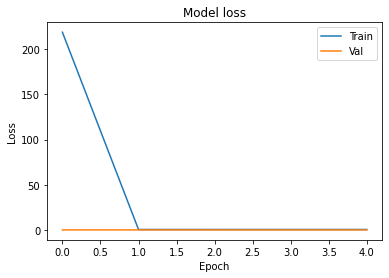

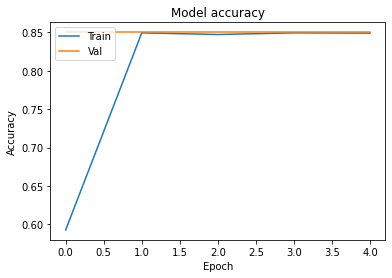

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

22
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       105
           1       0.85      1.00      0.92       596

    accuracy                           0.85       701
   macro avg       0.43      0.50      0.46       701
weighted avg       0.72      0.85      0.78       701



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(33.0, 0.5, 'Y_true')

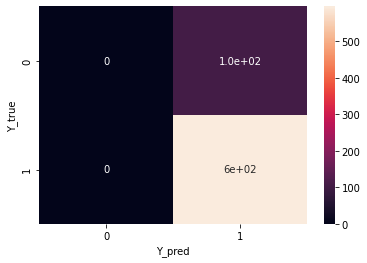

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
# TODO: report confusion matrix on test set (test_gen)
Y_true = []
Y_pred = []
print(len(test_gen))
for i in range(len(test_gen)):
  X, y = test_gen[i]
  Y_pred.append(model.predict(X))
  Y_true.append(y)
Y_true = np.vstack(Y_true)
Y_true = np.argmax(Y_true, axis=1)
Y_pred = np.vstack(Y_pred)
Y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(Y_true, Y_pred))

cmat = confusion_matrix(Y_true, Y_pred)
import seaborn as sn
sn.heatmap(cmat, annot=True)
plt.xlabel('Y_pred')
plt.ylabel('Y_true')

In [ ]:
acc = np.mean(Y_true == Y_pred)
acc

0.849607982893799